#Introduction
##Objective:
Explanation of Neural Style Transfer: combining the content of one image with the style of another.

Framework: TensorFlow and TensorFlow Hub.
##Key Concepts:
Content Image: The image whose structure and details we retain. (vpkhoa.jpg)

Style Image: The image whose visual style (colors, patterns) is applied to the content. (Starry Night.jpg)


In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
style_path = '/content/drive/MyDrive/CycleGan/Starry Night.jpg'
content_path = '/content/drive/MyDrive/CycleGan/lab.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

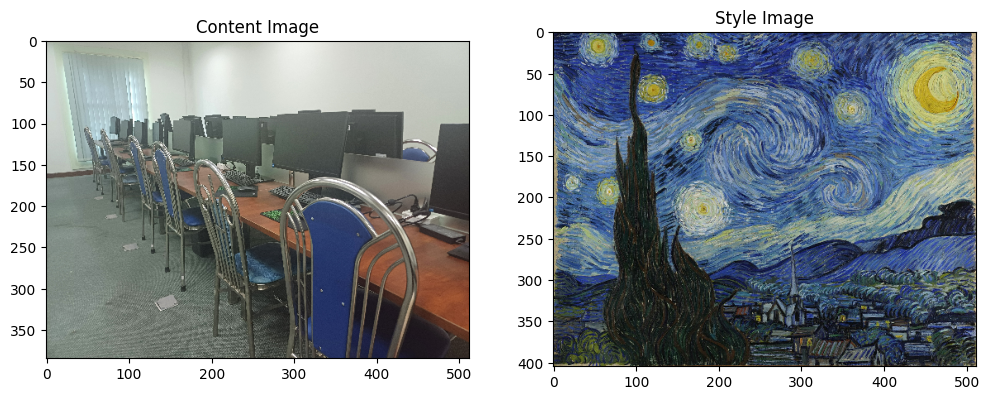

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#Neural Style Transfer Model
TensorFlow Hub Model:
1.   Using the pre-trained model from tensorflow_hub for arbitrary image stylization.
2.   Applying style transfer by feeding content and style images to the model.
3.   Displaying the first stylized image.

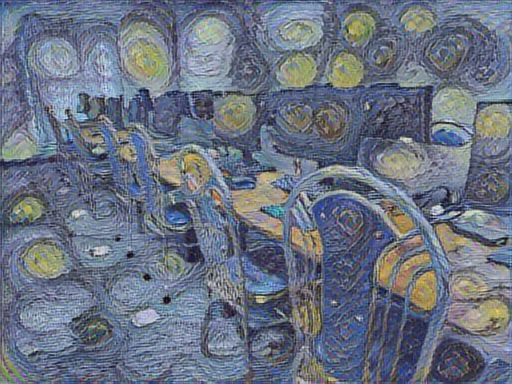

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

#VGG19 Model for Style and Content Extraction
##VGG19 Network:
Pre-trained VGG19 model used to extract features from images.

Layers of Interest:
*   Content Layers: block5_conv2.
*   Style Layers: Several early convolution layers in different blocks.
##Why VGG19?
It captures hierarchical features that help isolate content and style representations.


In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[('folding_chair', 0.21562585),
 ('dining_table', 0.16439797),
 ('restaurant', 0.11946835),
 ('crutch', 0.02086683),
 ('patio', 0.020787183)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#Style and Content Extraction
##Feature Extraction:
* Using vgg_layers() function to create a model that returns the outputs of specific layers.
* Extracting style and content from their respective layers.
* Key Statistics: Layer-wise statistics of output shape, min, max, and mean values to monitor extracted features.

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  674.33826
  mean:  24.303293

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  3019.699
  mean:  150.80452

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7773.047
  mean:  145.05663

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  17166.629
  mean:  571.5989

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3924.4873
  mean:  49.09743



#StyleContentModel Class
Custom Model:
* Merging both style and content extraction in a StyleContentModel class.
* Processes inputs and generates style and content feature maps.
* Uses gram_matrix() for style features to calculate the correlation of pixel intensities.

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.060039684
    max:  24834.54
    mean:  339.86853

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  73356.88
    mean:  10743.535

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  181038.14
    mean:  10571.674

   block4_conv1
    shape:  (1, 512, 512)
    min:  12.167523
    max:  2021302.0
    mean:  165819.75

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  74073.53
    mean:  1502.9495

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1033.205
    mean:  14.016643


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#Style and Content Loss
##Loss Function:
* Style Loss: Measures the difference between the gram matrices of the style outputs and the style targets.
* Content Loss: Measures the difference between the content outputs and the content targets.
* Combined Loss: A weighted sum of style loss and content loss.

In [ ]:
style_weight=1e-3
content_weight=1e3

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

#Optimization Process
Optimization Algorithm:
1. Adam optimizer used with a custom learning rate and parameters.
2. Training Loop:
* The loop runs for a set number of epochs and steps per epoch.
* Gradients are calculated and applied to update the image.
* Image values are clipped between 0 and 1 to avoid artifacts.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

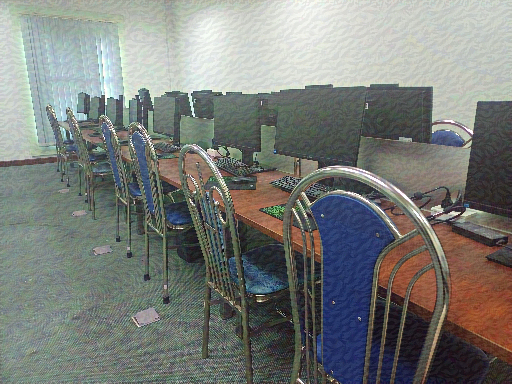

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

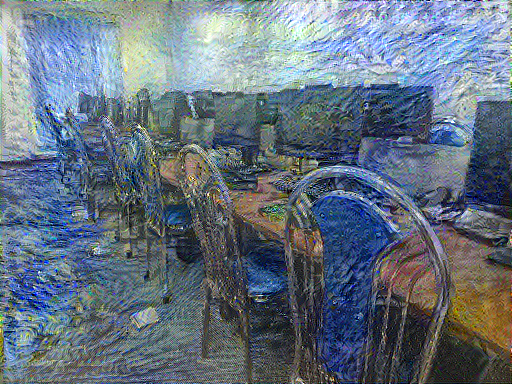

Train step: 1500
Total time: 121.4


In [ ]:
import time
start = time.time()

epochs = 15
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

#High-Pass Filters and Sobel Edges
##Edge Detection:
Horizontal and vertical deltas are calculated to visualize changes in image structure.
##Sobel Edge Detection:
Applying Sobel filters to detect edges and gradients in the image.

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

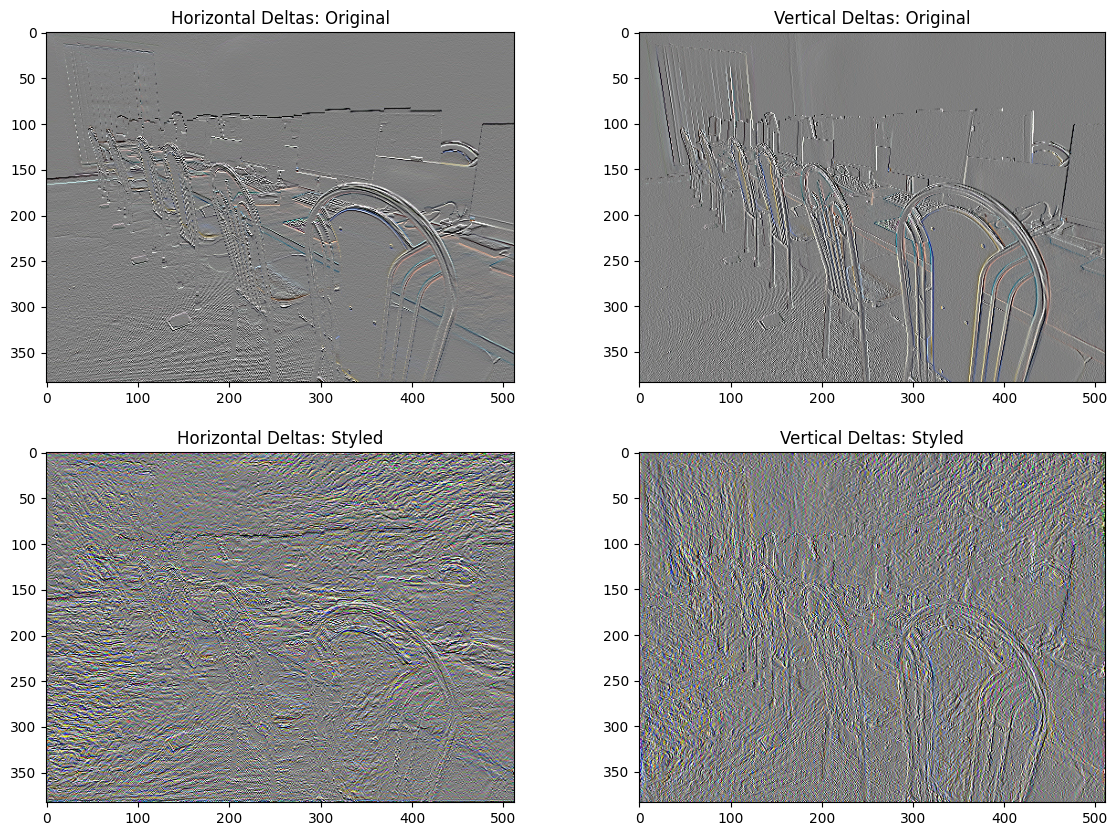

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

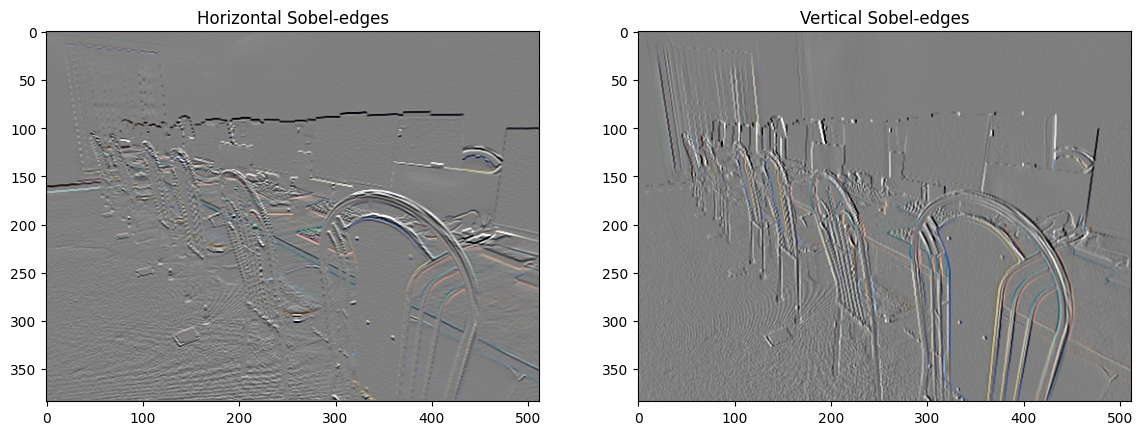

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

#Total Variation Loss
##Regularization:
* Total variation loss is applied to smooth out the image and reduce noise.
* Helps ensure the resulting stylized image has fewer high-frequency artifacts.
* The regularization term encourages spatial smoothness.


In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

109724.375

In [ ]:
tf.image.total_variation(image).numpy()

array([109724.375], dtype=float32)

In [ ]:
total_variation_weight=20

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

#Final Training Results
##Training Loop Visualization:
* The stylized image is updated and displayed after each epoch.
* Real-time updates during training show how the image evolves to match the style while preserving the content.
* Timing: Measure and display the total training time for the process.

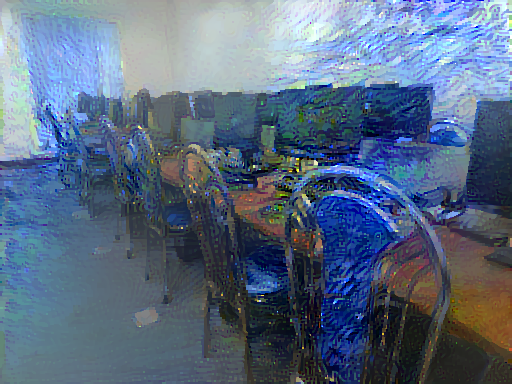

Train step: 1500
Total time: 123.2


In [ ]:
import time
start = time.time()

epochs = 15
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = 'vpkhoa_output.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>